# 5. Localization

In [1]:
from pathlib import Path
from pickle import load

import covseisnet as csn

## Read covariance

In [2]:
# Save
with open("../data/undervolc_covariance.pickle", "rb") as file:
    data = load(file)
    times = data["times"]
    frequencies = data["frequencies"]
    covariances = data["covariances"]



## Plot correlation

Text(0, 0.5, 'Pairwise distance (km)')

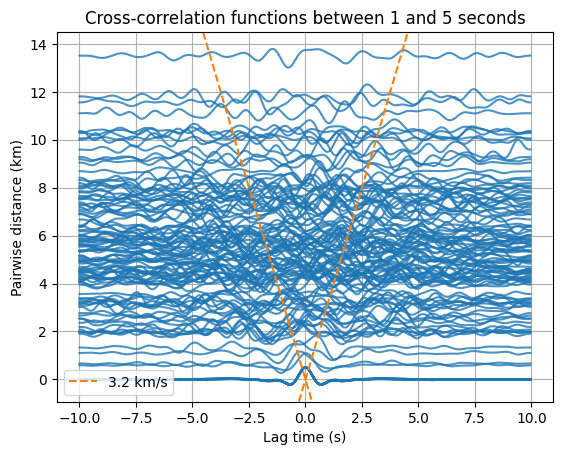

In [3]:
import matplotlib.pyplot as plt

frequency_band = 0.2, 1

# Calculate cross-correlation
lags, pairs, cross_correlation = csn.calculate_cross_correlation_matrix(
    covariances
)

# Get inter-station distance
distances = csn.pairwise_great_circle_distances_from_stats(
    cross_correlation.stats
)

# Bandpass filter
# cross_correlation = cross_correlation.mean(axis=1)
cross_correlation = cross_correlation[:, 0]
cross_correlation = cross_correlation.bandpass(frequency_band)
cross_correlation = cross_correlation.taper()

# Plot
fig, ax = plt.subplots()
for i_pair, pair in enumerate(pairs):
    cc = cross_correlation[i_pair] / abs(cross_correlation[i_pair]).max() * 0.5
    ax.plot(lags, cc + distances[i_pair], color="C0", alpha=0.8)

# Plot some velocity
v = 3.2
ax.axline((0, 0), slope=v, color="C1", label=f"{v} km/s", ls="--")
ax.axline((0, 0), slope=-v, color="C1", ls="--")

ax.legend(loc="lower left")
ax.grid()
periods = list(sorted(int(1 / f) for f in frequency_band))
ax.set_title(
    f"Cross-correlation functions between {periods[0]} and {periods[1]} seconds"
)
ax.set_xlabel("Lag time (s)")
ax.set_ylabel("Pairwise distance (km)")

In [4]:
# Read
stream = csn.read("../data/undervolc.mseed")

# Pre-process
stream.normalize(global_max=True)
stream.filter("highpass", freq=0.5)
stream.time_normalize(method="smooth", smooth_length=1001)
stream.taper(max_percentage=0.01)
stream.assign_coordinates("../data/undervolc.xml")

In [5]:
import numpy as np
import h5py as h5
from covseisnet.travel_times import TravelTimes, DifferentialTravelTimes

# Calculate cross-correlation
lags, pairs, correlations = csn.calculate_cross_correlation_matrix(covariances)

# Pre-process the cross-correlation functions
correlations = correlations.taper(0.1)
correlations = correlations.bandpass(frequency_band=(1, 5))
correlations = correlations.envelope()
correlations = correlations.smooth(sigma=30)
correlations /= correlations.max(axis=-1, keepdims=True)
correlations = correlations.squeeze()

# Read the model
filepath_model = Path("../data/undervolc_vs_mordret_2015.h5").absolute()
velocity_field_name = "Vs"

# The h5 file contains the velocity model in a 3D grid with the following
# dimensions in order: longitude, latitude, depth. The depth and velocity are
# in meters and meters per second, respectively.
with h5.File(filepath_model, "r") as velocity_model:

    # Coordinates
    lon = np.array(velocity_model["longitude"])
    lat = np.array(velocity_model["latitude"])
    depth = np.array(velocity_model["depth"])

    # Velocity
    velocity = np.array(velocity_model[velocity_field_name])

# Get extent
model = csn.velocity.model_from_grid(lon, lat, depth, velocity)
# model[np.isnan(model)] = 340/1000


# Obtain the travel times
travel_times = {
    trace.stats.station: TravelTimes(stats=trace.stats, velocity_model=model)
    for trace in stream
}

# Calculate differential travel times
differential_travel_times = {}
for pair in pairs:
    station_1, station_2 = pair
    tt1 = travel_times[station_1]
    tt1[np.isinf(tt1)] = np.nan
    tt2 = travel_times[station_2]
    tt2[np.isinf(tt2)] = np.nan
    differential_travel_times[pair] = DifferentialTravelTimes(tt1, tt2)

Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.


/home/eric/WORK/software/covseisnet/covseisnet/travel_times.py:224: RuntimeWarning: divide by zero encountered in scalar divide
  solver.solve()


Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.
Using Pykonal to calculate travel times.


In [6]:
print(differential_travel_times[("UV01", "UV02")])

DifferentialTravelTimes(
	lon: [55.55, 55.85] with 151 points
	lat: [-21.38, -21.12] with 130 points
	depth: [-2.80, 3.20] with 61 points
	mesh: 1,197,430 points
	nan values: 372,664 points
	min: -6.508
	max: 6.920
)


(<Figure size 500x500 with 4 Axes>,
 {'xy': <Axes: label='xy', ylabel='Latitude (º)'>,
  'zy': <Axes: label='zy', xlabel='Depth (km)'>,
  'xz': <Axes: label='xz', xlabel='Longitude (º)', ylabel='Depth (km)'>,
  'cb': <Axes: label='cb', xlabel='Time difference (s)'>})

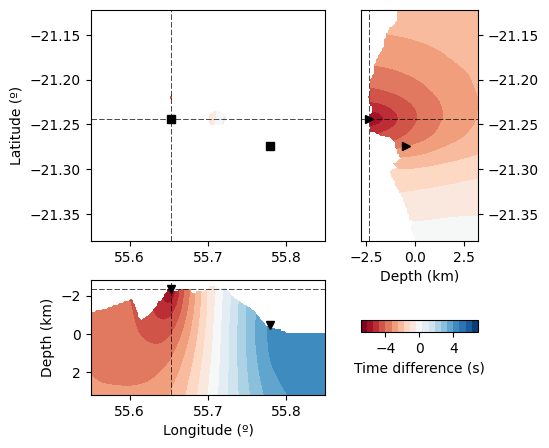

In [7]:
csn.plot.grid3d(
    differential_travel_times[("UV01", "UV02")],
    label="Time difference (s)",
)

## Coherence

/home/eric/WORK/software/covseisnet/covseisnet/backprojection.py:82: RuntimeWarning: invalid value encountered in cast
  lags = np.round(self.moveouts[pair] * sampling_rate).astype(int)


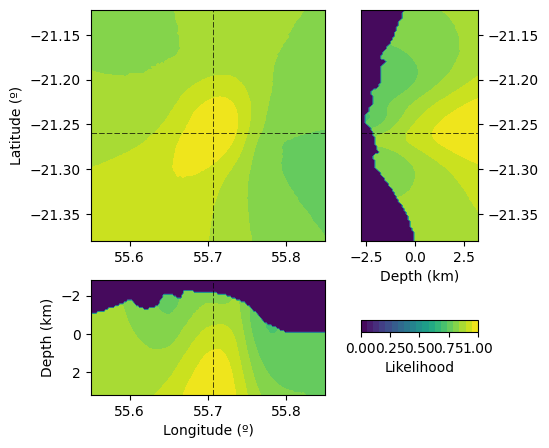

In [8]:
from covseisnet.backprojection import DifferentialBackProjection

# Calculate likelihood
backprojection = DifferentialBackProjection(differential_travel_times)
backprojection.calculate_likelihood(cross_correlation=correlations[-1])

# Plot likelihood in 3D
ax = csn.plot.grid3d(backprojection, cmap="viridis", label="Likelihood")